In [1]:
import argparse
import os
import requests
from datetime import datetime
import json

from lib.utils import *
from lib.datasets import EEGDataset
from torch.utils.data import DataLoader,TensorDataset
from torch.nn.functional import softmax,batch_norm,relu
from torch import nn
import torch
from lib.models import ResNet as MODEL
device = 'cuda'

data_dir = 'data_pt'
train_dataloader = DataLoader(EEGDataset(dir=f'{data_dir}/train',labels=f'{data_dir}/y_train.pt'), batch_size=64, shuffle=True)
test_dataloader = DataLoader(EEGDataset(dir=f'{data_dir}/test',labels=f'{data_dir}/y_test.pt'), batch_size=64, shuffle=False)

warmstart = False

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = MODEL()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
train_losses = []
dev_losses = []

if warmstart:
    checkpoint = torch.load('model_106_0.3189.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    EPOCH = checkpoint['epoch']
else:
    EPOCH = 0

In [ ]:
for i in range(100):
    training_loss = 0
    model.train()
    for (X,y) in tqdm(train_dataloader):
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    train_losses.append(training_loss/len(train_dataloader))
    testing_loss = 0
    model.eval()
    for (X,y) in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        testing_loss += loss.item()
    dev_losses.append(testing_loss/len(test_dataloader))
    print(f'Epoch {EPOCH} Train: {training_loss/len(train_dataloader)} Test: {testing_loss/len(test_dataloader)}')
    torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'model_class':MODEL(),
            'train_loss': train_losses[-1],
            'dev_loss': dev_losses[-1],
            }, f'model_{EPOCH}_{dev_losses[-1]:.4f}.pt')
    EPOCH += 1
    plt.plot(train_losses,label='train')
    plt.plot(dev_losses,label='validation')
    plt.savefig('loss.jpg',dpi=200)
    plt.close()

In [2]:
checkpoint = torch.load('model_106_0.3189.pt',map_location=torch.device('cpu'))
model = checkpoint['model_class']
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
EPOCH = checkpoint['epoch']

NameError: name 'optimizer' is not defined

/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


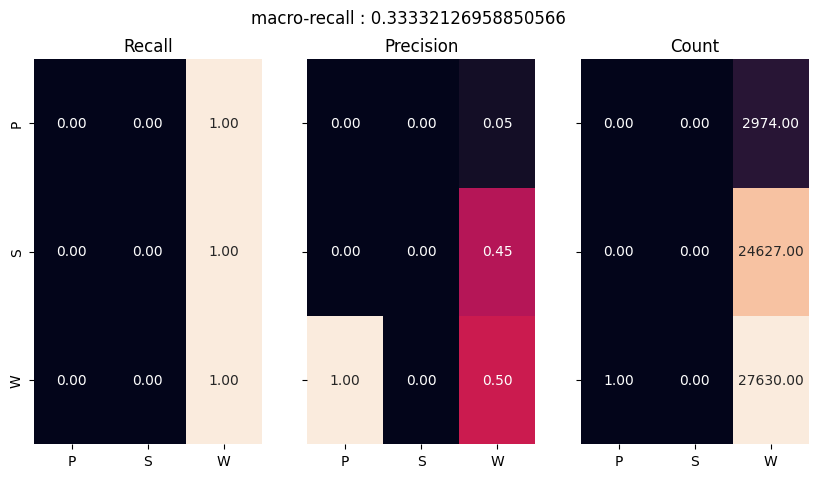

In [4]:
# test confusion matrices
y_true = torch.Tensor()
y_pred = torch.Tensor()
for (X,y) in test_dataloader:
    y_true = torch.cat([y_true,y.argmax(axis=1)])
    y_pred = torch.cat([y_pred,softmax(model(X),dim=1).argmax(axis=1)])
y_pred = y_pred
cms(y_true=y_true,y_pred=y_pred,current_date=None)